# Transfer Learning



 - Customizing a pre-trained model to perfom tasks specific to our requirement
 - Since Pretrained models are trained on lakhs of common world object, use them only to extract features

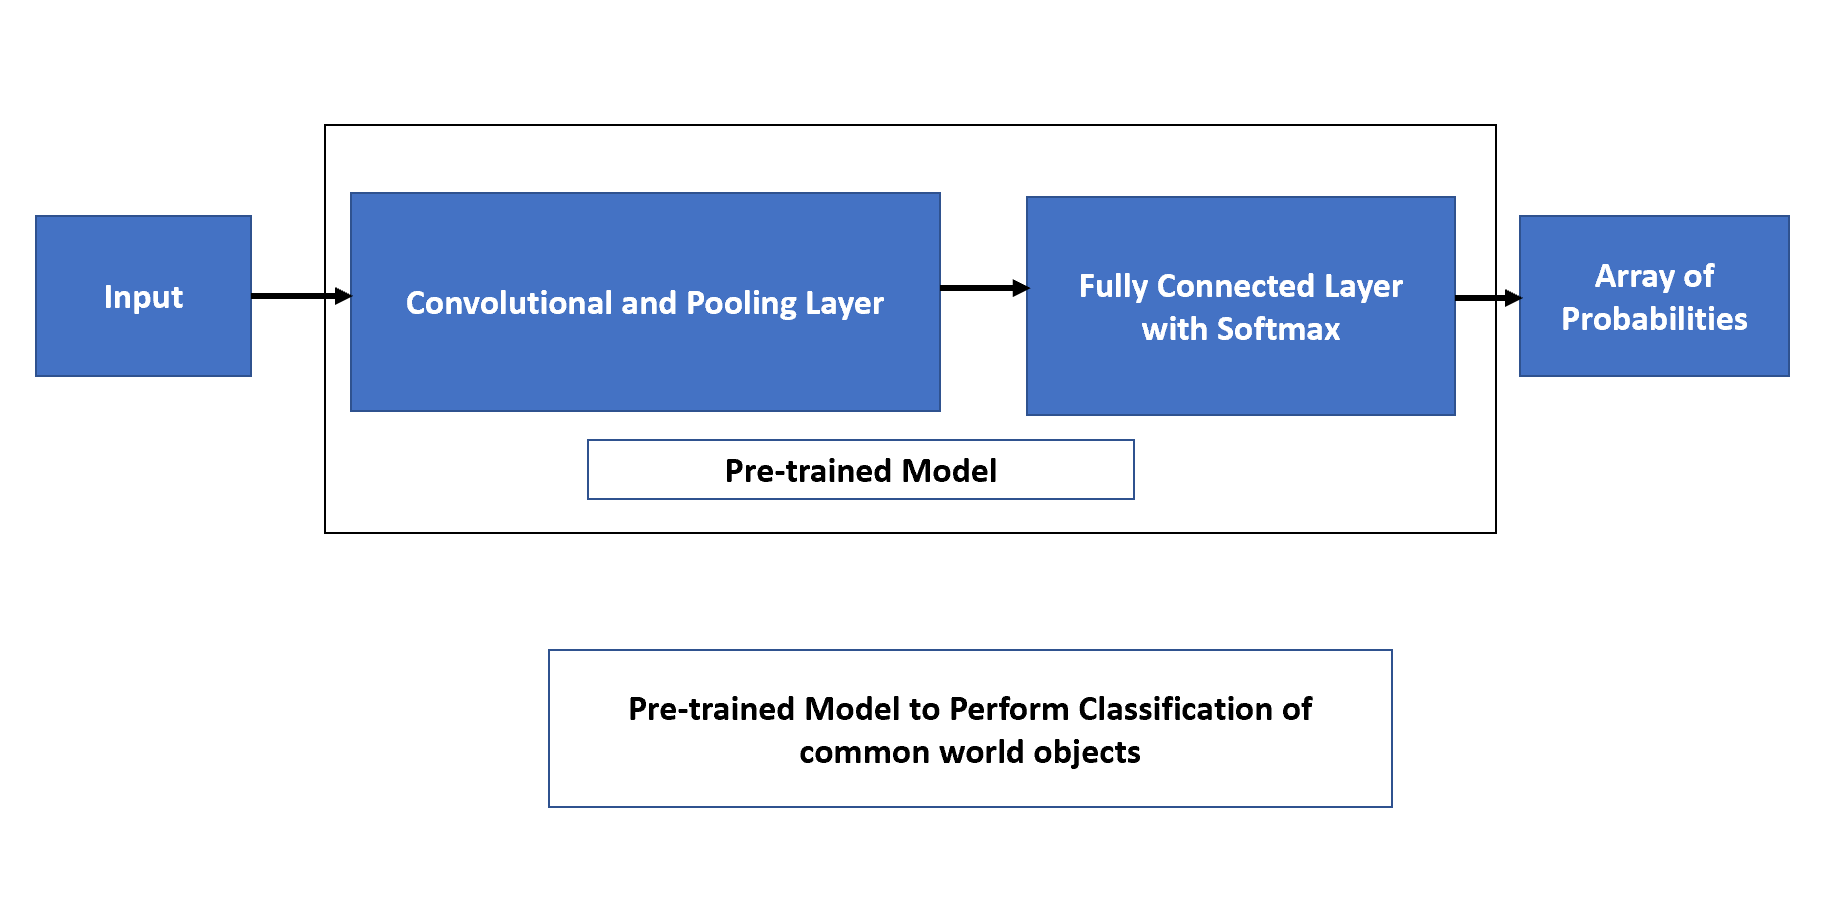

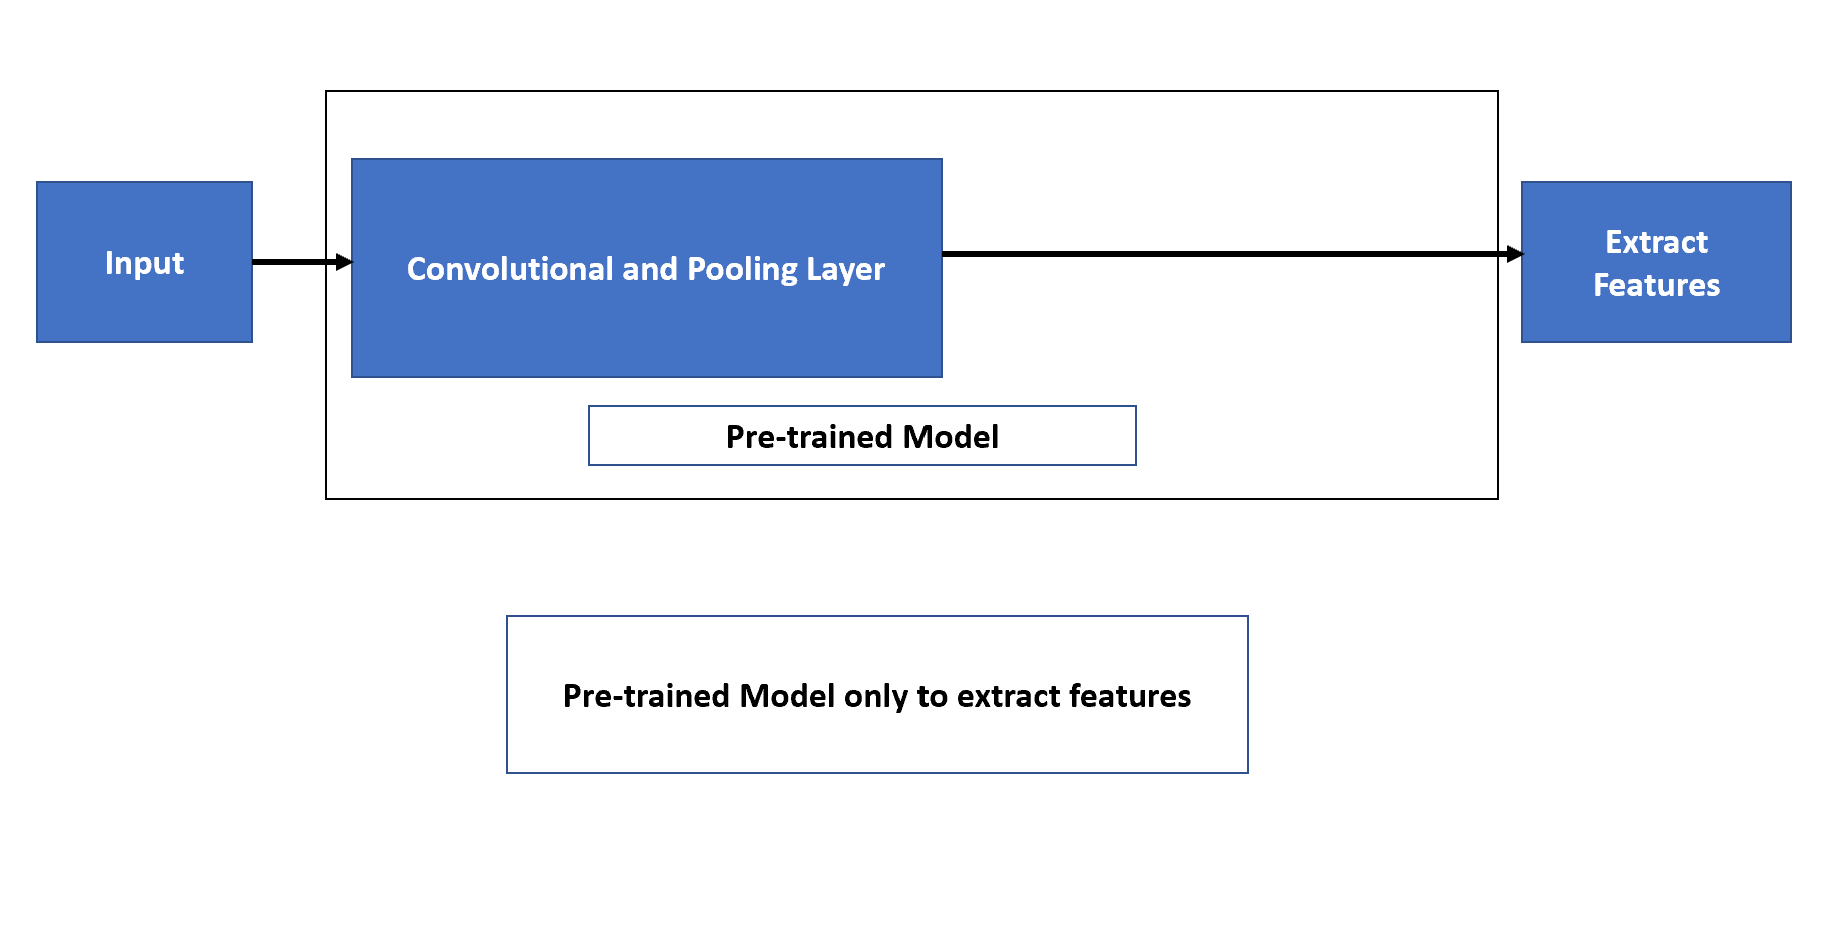

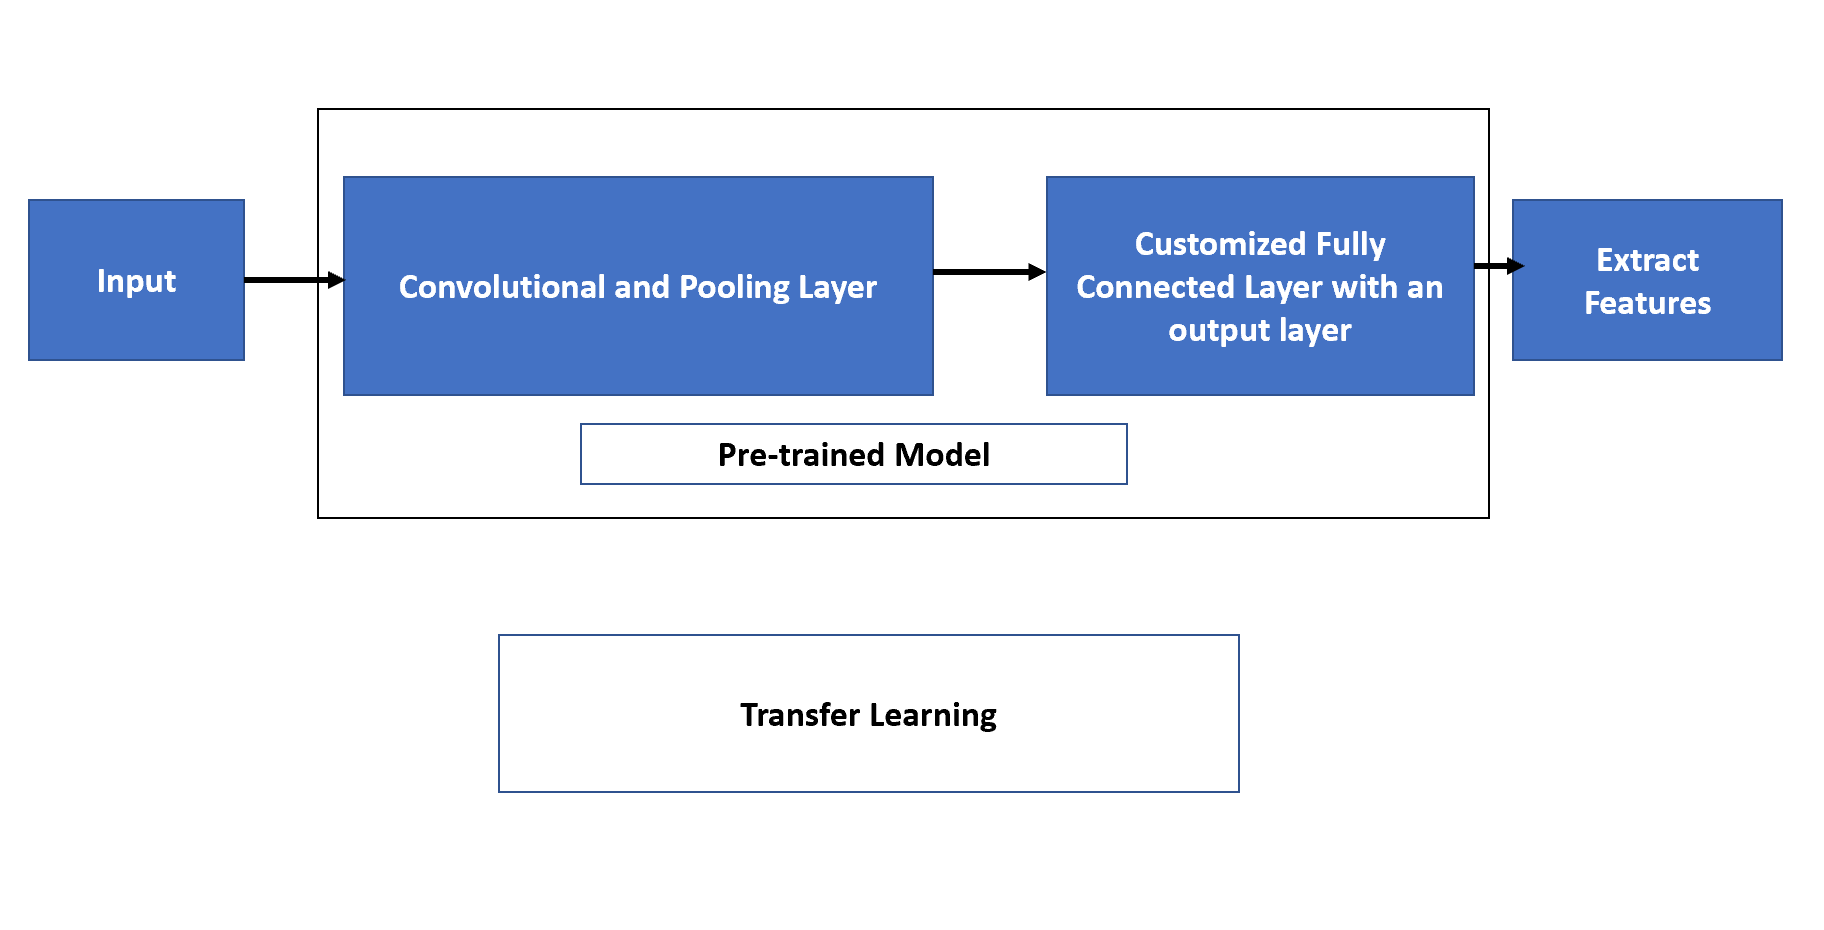



*<font color=blue>In last diagram, the last block, it is Array of Probabilities not extract features*
 - the Weights of the convolutional layer is reused from a pre-trained model and we end up training only the customized fully connected layer & output layer.
 - So in a way u r partly re-using it, u r transfering the way u extracted features from a pre-trained model (already trained weights) & feeding to ur customised fully connected layer (weight training will happen here) to classify o/p.

*After u have exausted all ur techniques on ur own model, u try to apply transfer learning at last.*

In [1]:
##Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

In [2]:
base_model = VGG16(input_shape=(64,64,3), 
                   include_top=False,   # to chop off all layers after convolution layer
                   weights='imagenet')

2023-09-30 20:45:53.456408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
base_model.trainable = False  # just want to re-use convolution layers

In [4]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [5]:
# Create additional layers 
flatten_layer=Flatten()

prediction_layer = Dense(3, activation='softmax')

In [6]:
classifier = Sequential([
    base_model,
    flatten_layer,
    prediction_layer
])

In [7]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 14,720,835
Trainable params: 6,147
Non-trainable params: 14,714,688
_________________________________________________________________


*<font color=blue>We r going to train 6147 parameters here, rest we just use pre-trained weights for feature extraction*

In [9]:
## data importing and transforming and scaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)  # follow VGG16 pre-processing

*preprocessing_function=preprocess_input, this will ensure that ur i/p data is compatible to be fed to not ur convolution layers but to VGG16 compatible convolution layers.*

In [10]:
## Scaling test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
## Importing training data
train_set = train_datagen.flow_from_directory('data/ekm_ds/train',
                                              target_size=(64,64),
                                              class_mode='categorical')

Found 132 images belonging to 3 classes.


In [12]:
train_set.samples

132

In [13]:
train_set.class_indices

{'Earphones': 0, 'Keychain': 1, 'Marker': 2}

In [14]:
## Importng test data
test_set = test_datagen.flow_from_directory('data/ekm_ds/test',
                                            target_size=(64, 64),
                                            class_mode='categorical')

Found 47 images belonging to 3 classes.


In [15]:
## fitting model to images
classifier.fit(train_set,
               epochs=5, 
               steps_per_epoch= train_set.samples//32 , 
               validation_data=test_set)

Epoch 1/5
4/4 [==============================] - 25s 8s/step - loss: 14.8528 - accuracy: 0.4400 - val_loss: 3.8655 - val_accuracy: 0.6809
Epoch 2/5
4/4 [==============================] - 20s 5s/step - loss: 4.0364 - accuracy: 0.7300 - val_loss: 1.0931 - val_accuracy: 0.9362
Epoch 3/5
4/4 [==============================] - 24s 6s/step - loss: 0.6972 - accuracy: 0.9219 - val_loss: 0.1041 - val_accuracy: 0.9787
Epoch 4/5
4/4 [==============================] - 20s 7s/step - loss: 0.3588 - accuracy: 0.9600 - val_loss: 1.0749e-04 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 20s 5s/step - loss: 0.0465 - accuracy: 0.9900 - val_loss: 1.2428e-07 - val_accuracy: 1.0000


In [16]:
## prediction of single new data
import numpy as np
from tensorflow.keras.preprocessing import image
test_image= image.load_img('data/ekm_ds/inference/e1.jpg',target_size =(64,64))

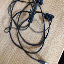

In [17]:
test_image

In [18]:
## Convert image to array
test_image = image.img_to_array(test_image)


In [19]:
## For single prediction change the dimension using axis. To remove problem of batch
test_image=test_image.reshape(1,64,64,3)

In [20]:
test_image = preprocess_input(test_image)

In [21]:
result = classifier.predict(test_image)

1/1 [==============================] - 0s 120ms/step


In [22]:
result=result.argmax()

In [23]:
## print label

if result == 0:
    prediction = 'Earphones'
elif result == 1:
    prediction = 'Keychain'
else:
    prediction = 'Marker'
    

In [24]:
prediction

'Earphones'

*Note*

For hyperparameter tuning in ML we use random search & grid search, for DL specially CNN with images this operations v.v. costly. But with neural nets we usually do trial & error which is still a shorter time than doing random/grid search.

Playing trial & Error with transfer learning is much simpler for hyperparameter tuning as most layers r fixed (already computed weights) rather than trying out with CNN. 